## imports

In [1]:
import json
import numpy as np
import pandas as pd
from tensorflow.keras import models, layers, utils
import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# file_path = r'./data/data.json'
f = open(file_path)
data =json.load(f)

df_train = pd.json_normalize(data['train']).drop(['pics', 'review_text', 'history_reviews'], axis=1)
df_val = pd.json_normalize(data['val']).drop(['pics', 'review_text', 'history_reviews'], axis=1)
df_test = pd.json_normalize(data['test']).drop(['pics', 'review_text', 'history_reviews'], axis=1)

# history_reviews are all other reviews of user!!!

In [4]:
print('number of users:', len(df_train['user_id'].unique()))
print('number of businesses:', len(df_train['business_id'].unique()))
df_train

number of users: 29596
number of businesses: 27896


,business_id,user_id,rating
0,60567465d335d0abfb415b26,101074926318992653684,4
1,6050fa9f5b4ccec8d5cae994,117065749986299237881,5
2,604be10877e81aaed3cc9a1e,106700937793048450809,4
3,60411e017cd8bf130362365a,101643045857250355161,5
4,604139dd7cd8bf1303624208,109802745326785766951,4
...,...,...,...
87008,604bad2d20f26f37fb9d7db0,116424268004501507050,3
87009,60417f132e57ebdea29c4b80,117588849143422747708,5
87010,6055c4233019cb0a47838a63,105232116717227512438,4
87011,60509067c53d98b3eace16a7,111963502676898067823,5


In [5]:
print('number of users:', len(df_val['user_id'].unique()))
print('number of businesses:', len(df_val['business_id'].unique()))
df_val

number of users: 3700
number of businesses: 7835


,business_id,user_id,rating
0,6049974fb1a0aaee3eefb0dd,112777069092124620875,5
1,6040f95d7cd8bf1303622198,116435353904842843088,5
2,60521c38d8c08f462b93e849,108930124171149144574,4
3,605440914c439864897ed9df,105287034927846928048,5
4,6050c60f5b4ccec8d5cae83e,112960187280808873275,5
...,...,...,...
10855,60416ef12e57ebdea29c43ea,109535394381266525122,5
10856,6050f768c53d98b3eace193d,116660163645292334931,5
10857,604720936f0b398c7116c5d3,114494880006135486241,5
10858,605331f811a96a1e3740a65d,110204697034501773042,4


In [6]:
print('number of users:', len(df_test['user_id'].unique()))
print('number of businesses:', len(df_test['business_id'].unique()))
df_test

number of users: 3700
number of businesses: 7880


,business_id,user_id,rating
0,604bf6a75041fa50c4bce594,108919790647235091207,5
1,604ee8b388c7af3f893e613b,108111397722253060630,5
2,605121e75b4ccec8d5caea76,114961509003938009497,5
3,6050d2cf9c93e55e75b72260,108970514621946615447,5
4,6046315010ec061e056b3f81,113922271624881467869,4
...,...,...,...
11010,6040b07cc6fcf1fddba0dfd5,117829863369063969255,5
11011,6056b2c9f69c7b1178070109,107024884024793098757,5
11012,604ad57db1a0aaee3eefbead,102202511962268105684,2
11013,605026f90f8302d2f838676d,102279422150937367692,5


## check if users are mutual

### there is no mutual user at all!! :)

In [7]:
users_train = df_train['user_id'].unique()
users_val = df_val['user_id'].unique()
users_test = df_test['user_id'].unique()

print('users_train:', len(users_train))
print('users_val:', len(users_val))
print('users_test:', len(users_test))

print('\ntrain_val', len(set(users_train).intersection(users_val)))
print('train_test', len(set(users_train).intersection(users_test)))
print('val_test', len(set(users_val).intersection(users_test)))


users_train: 29596
users_val: 3700
users_test: 3700

train_val 0
train_test 0
val_test 0


### some of businesses are mutual

In [8]:
businesses_train = df_train['business_id'].unique()
businesses_val = df_val['business_id'].unique()
businesses_test = df_test['business_id'].unique()

businesses_train_val = set(businesses_train).intersection(businesses_val)
businesses_train_test = set(businesses_train).intersection(businesses_test)
businesses_val_test = set(businesses_test).intersection(businesses_val)

print('train - val:', len(businesses_train), len(businesses_train_val), len(businesses_train) - len(businesses_train_val))
print('val - train:', len(businesses_val), len(businesses_train_val), len(businesses_val) - len(businesses_train_val))

print('\ntrain - test:', len(businesses_train), len(businesses_train_test), len(businesses_train) - len(businesses_train_test))
print('test - train:', len(businesses_test), len(businesses_train_test), len(businesses_test) - len(businesses_train_test))

print('\nval - test:', len(businesses_val), len(businesses_val_test), len(businesses_val) - len(businesses_val_test))
print('test - val:', len(businesses_test), len(businesses_val_test), len(businesses_test) - len(businesses_val_test))


train - val: 27896 6282 21614
val - train: 7835 6282 1553

train - test: 27896 6322 21574
test - train: 7880 6322 1558

val - test: 7835 2786 5049
test - val: 7880 2786 5094


## preprocess train data

In [9]:
df_businesses = pd.DataFrame(data = df_train['business_id'].unique(), columns = ['business_id'])
df_businesses["business_num"] = range(0, len(df_businesses))
df_businesses = df_businesses.join(df_train.groupby('business_id')['rating'].agg(['mean', 'count']), on='business_id')
df_businesses = df_businesses.rename(columns={"mean":"business_mean_rate", "count":"business_rate_count"})

df_businesses

,business_id,business_num,business_mean_rate,business_rate_count
0,60567465d335d0abfb415b26,0,4.593750,64
1,6050fa9f5b4ccec8d5cae994,1,4.000000,17
2,604be10877e81aaed3cc9a1e,2,4.333333,6
3,60411e017cd8bf130362365a,3,5.000000,1
4,604139dd7cd8bf1303624208,4,4.300000,10
...,...,...,...,...
27891,604fa6e79755094ba8abe4fe,27891,5.000000,1
27892,6055c17097d555cc6fb0cebd,27892,5.000000,1
27893,605728168cd0e3d69a52283c,27893,5.000000,1
27894,6056ab503019cb0a47838e09,27894,4.000000,1


In [10]:
df_users_train = pd.DataFrame(data = df_train['user_id'].unique(), columns = ['user_id'])
df_users_train = df_users_train.join(df_train.groupby('user_id')['rating'].agg(['mean', 'count']), on='user_id')
df_users_train = df_users_train.rename(columns={"mean":"user_mean_rate", "count":"user_rate_count"})

df_users_train

,user_id,user_mean_rate,user_rate_count
0,101074926318992653684,4.000000,12
1,117065749986299237881,4.500000,2
2,106700937793048450809,4.666667,3
3,101643045857250355161,5.000000,3
4,109802745326785766951,4.666667,3
...,...,...,...
29591,112577401510712876116,3.000000,2
29592,101871227522334882257,2.000000,2
29593,100052171671537889028,5.000000,2
29594,116256574703357887153,4.000000,2


In [11]:
df_train_new = df_train.join(df_users_train.set_index('user_id'), on='user_id')
df_train_new = df_train_new.join(df_businesses.set_index('business_id'), on='business_id')
df_train_new = df_train_new[["user_id", "user_mean_rate", "user_rate_count", "business_num", "business_mean_rate", "business_rate_count", "rating"]]

df_train_new

,user_id,user_mean_rate,user_rate_count,business_num,business_mean_rate,business_rate_count,rating
0,101074926318992653684,4.000000,12,0,4.593750,64,4
1,117065749986299237881,4.500000,2,1,4.000000,17,5
2,106700937793048450809,4.666667,3,2,4.333333,6,4
3,101643045857250355161,5.000000,3,3,5.000000,1,5
4,109802745326785766951,4.666667,3,4,4.300000,10,4
...,...,...,...,...,...,...,...
87008,116424268004501507050,3.666667,3,23459,4.000000,2,3
87009,117588849143422747708,5.000000,2,50,4.290323,31,5
87010,105232116717227512438,4.000000,2,24465,3.666667,3,4
87011,111963502676898067823,5.000000,2,1031,4.571429,14,5


## preprocess validation data

In [12]:
df_users_val = pd.DataFrame(data = df_val['user_id'].unique(), columns = ['user_id'])
df_users_val = df_users_val.join(df_val.groupby('user_id')['rating'].agg(['mean', 'count']), on='user_id')
df_users_val = df_users_val.rename(columns={"mean":"user_mean_rate", "count":"user_rate_count"})

df_users_val

,user_id,user_mean_rate,user_rate_count
0,112777069092124620875,4.80,5
1,116435353904842843088,5.00,4
2,108930124171149144574,4.75,8
3,105287034927846928048,5.00,2
4,112960187280808873275,4.50,2
...,...,...,...
3695,112224414655073192163,4.50,2
3696,116496181062539312994,5.00,2
3697,110713940123262893694,4.00,2
3698,114696322409080883615,5.00,2


In [13]:
df_val_new = df_val.join(df_users_val.set_index('user_id'), on='user_id', how='inner')
df_val_new = df_val_new.join(df_businesses.set_index('business_id'), on='business_id', how='inner')
df_val_new = df_val_new[["user_id", "user_mean_rate", "user_rate_count", "business_num", "business_mean_rate", "business_rate_count", "rating"]]

df_val_new

,user_id,user_mean_rate,user_rate_count,business_num,business_mean_rate,business_rate_count,rating
0,112777069092124620875,4.8,5,9585,5.000000,7,5
1309,112777069092124620875,4.8,5,24797,4.000000,1,5
1716,112777069092124620875,4.8,5,1338,5.000000,2,4
2433,112777069092124620875,4.8,5,18576,4.000000,2,5
6140,105699432238952207558,4.0,2,18576,4.000000,2,3
...,...,...,...,...,...,...,...
10424,116496181062539312994,5.0,2,10121,4.500000,2,5
10504,116496181062539312994,5.0,2,9003,5.000000,3,5
10496,110713940123262893694,4.0,2,27399,2.000000,1,4
10521,114696322409080883615,5.0,2,22812,5.000000,1,5


## preprocess test data

In [14]:
df_users_test = pd.DataFrame(data = df_test['user_id'].unique(), columns = ['user_id'])
df_users_test = df_users_test.join(df_test.groupby('user_id')['rating'].agg(['mean', 'count']), on='user_id')
df_users_test = df_users_test.rename(columns={"mean":"user_mean_rate", "count":"user_rate_count"})

df_users_test

,user_id,user_mean_rate,user_rate_count
0,108919790647235091207,4.333333,3
1,108111397722253060630,5.000000,3
2,114961509003938009497,5.000000,3
3,108970514621946615447,4.750000,4
4,113922271624881467869,3.888889,9
...,...,...,...
3695,103439820731085014373,4.000000,2
3696,111287365997510164326,4.500000,2
3697,101418788029065557629,5.000000,2
3698,104131863745467746244,4.500000,2


In [15]:
df_test_new = df_test.join(df_users_test.set_index('user_id'), on='user_id', how='inner')
df_test_new = df_test_new.join(df_businesses.set_index('business_id'), on='business_id', how='inner')
df_test_new = df_test_new[["user_id", "user_mean_rate", "user_rate_count", "business_num", "business_mean_rate", "business_rate_count", "rating"]]

df_test_new

,user_id,user_mean_rate,user_rate_count,business_num,business_mean_rate,business_rate_count,rating
1556,108919790647235091207,4.333333,3,6637,4.428571,7,3
6987,116725641365123730414,3.500000,2,6637,4.428571,7,4
2692,108919790647235091207,4.333333,3,674,4.000000,3,5
1,108111397722253060630,5.000000,3,2279,4.727273,22,5
1884,117907699439920972468,4.000000,3,2279,4.727273,22,4
...,...,...,...,...,...,...,...
10574,100591388576126908042,4.500000,2,22750,5.000000,2,4
10810,103439820731085014373,4.000000,2,24267,5.000000,1,4
10859,101418788029065557629,5.000000,2,17337,4.666667,3,5
10930,104131863745467746244,4.500000,2,2001,4.666667,3,5


## Network

In [16]:
embeddings_size = 32

# Users
input_user_mean_rate = layers.Input(name="input_user_mean_rate", shape=(1,))
dense_user_mean_rate = layers.Dense(name="dense_user_mean_rate", units=embeddings_size)(input_user_mean_rate)

input_user_rate_count = layers.Input(name="input_user_rate_count", shape=(1,))
dense_user_rate_count = layers.Dense(name="dense_user_rate_count", units=embeddings_size)(input_user_rate_count)

# Businesses
input_business_num = layers.Input(name="input_business_num", shape=(1,))
embedding_business_num = layers.Embedding(name="embedding_business_num", input_dim=len(businesses_train), output_dim=embeddings_size)(input_business_num)
reshape_business_num = layers.Reshape(name='reshape_business_num', target_shape=(embeddings_size,))(embedding_business_num)

input_business_mean_rate = layers.Input(name="input_business_mean_rate", shape=(1,))
dense_business_mean_rate = layers.Dense(name="dense_business_mean_rate", units=embeddings_size)(input_business_mean_rate)

input_business_rate_count = layers.Input(name="input_business_rate_count", shape=(1,))
dense_business_rate_count = layers.Dense(name="dense_business_rate_count", units=embeddings_size)(input_business_rate_count)

# Concatenate
concat_layer = layers.concatenate([
            dense_user_mean_rate,
            dense_user_rate_count,
            reshape_business_num,
            dense_business_mean_rate,
            dense_business_rate_count
        ], name="concat_layer")
output_layer = layers.Dense(1, activation='sigmoid', name="output_layer")(concat_layer)

# Predict ratings (1)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(output_layer)

# Compile
model = models.Model(outputs=y_out, name="CollaborativeFiltering",
                    inputs=[
                        input_user_mean_rate,
                        input_user_rate_count,
                        input_business_num,
                        input_business_mean_rate,
                        input_business_rate_count
                    ])
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])

model.summary()

Model: "CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_business_num (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 input_user_mean_rate (InputLay  [(None, 1)]         0           []                               
 er)                                                                                              
                                                                                                  
 input_user_rate_count (InputLa  [(None, 1)]         0           []                               
 yer)                                                                        

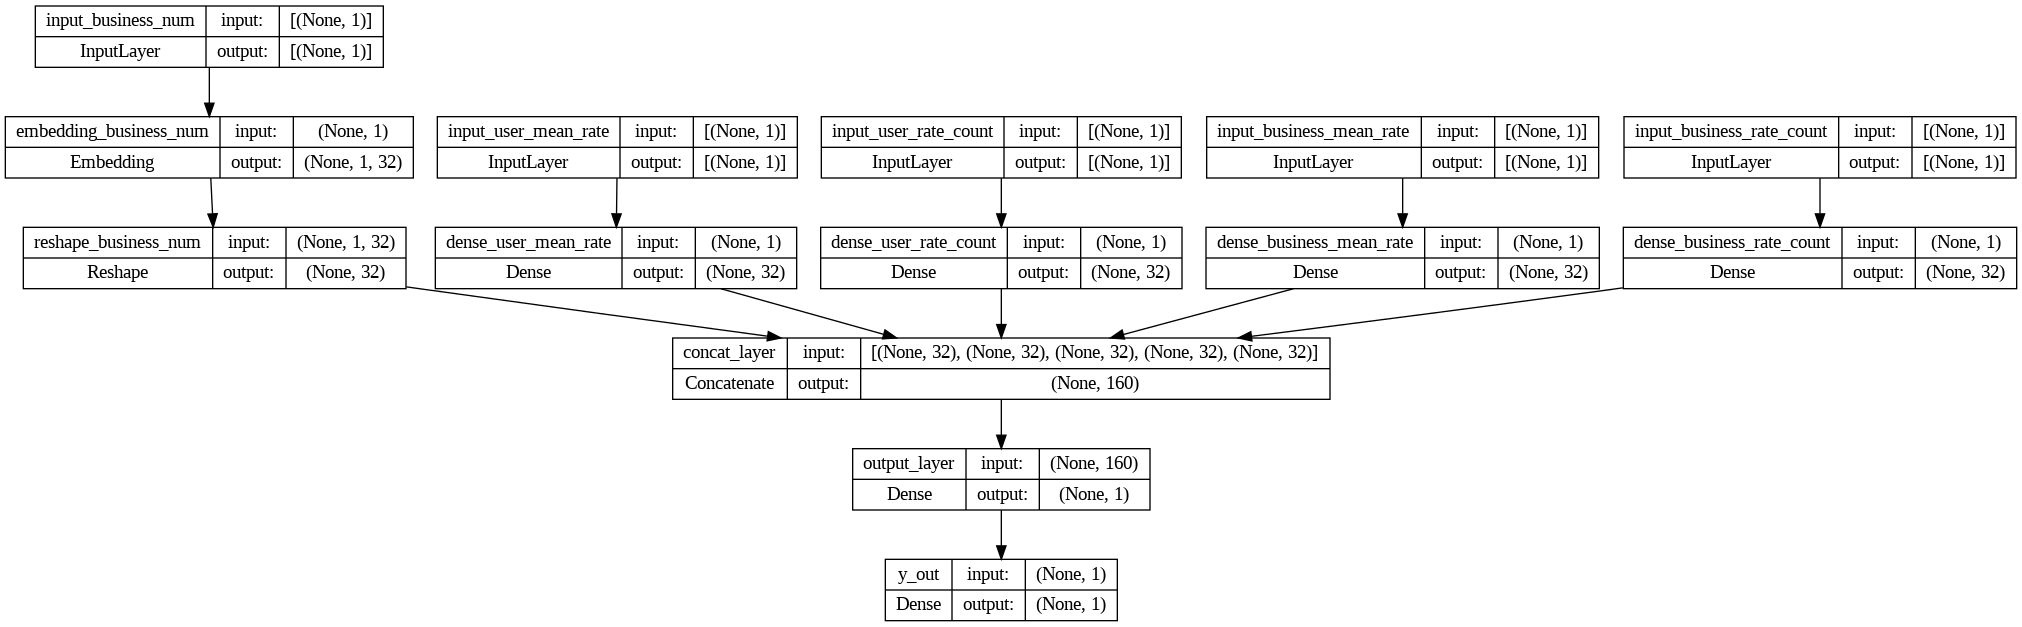

In [17]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Train

In [18]:
x_train = [
        df_train_new["user_mean_rate"],
        df_train_new["user_rate_count"],
        df_train_new["business_num"],
        df_train_new["business_mean_rate"],
        df_train_new["business_rate_count"]
    ]

x_val = [
        df_val_new["user_mean_rate"],
        df_val_new["user_rate_count"],
        df_val_new["business_num"],
        df_val_new["business_mean_rate"],
        df_val_new["business_rate_count"]
    ]

history = model.fit(
        x=x_train,
        y=df_train_new["rating"].astype(np.float32),
        epochs=50,
        batch_size=128,
        shuffle=True,
        verbose=1,
        validation_data=(x_val, df_val_new["rating"].astype(np.float32))
    )

Epoch 1/50
680/680 [==============================] - 12s 8ms/step - loss: 4.1410 - mean_absolute_percentage_error: 92.2455 - val_loss: 3.7984 - val_mean_absolute_percentage_error: 83.7408
Epoch 2/50
680/680 [==============================] - 3s 4ms/step - loss: 3.4500 - mean_absolute_percentage_error: 75.7874 - val_loss: 3.1331 - val_mean_absolute_percentage_error: 68.4779
Epoch 3/50
680/680 [==============================] - 4s 5ms/step - loss: 2.7933 - mean_absolute_percentage_error: 61.1208 - val_loss: 2.4785 - val_mean_absolute_percentage_error: 54.0940
Epoch 4/50
680/680 [==============================] - 4s 7ms/step - loss: 2.1641 - mean_absolute_percentage_error: 47.6671 - val_loss: 1.8682 - val_mean_absolute_percentage_error: 41.4287
Epoch 5/50
680/680 [==============================] - 3s 5ms/step - loss: 1.5740 - mean_absolute_percentage_error: 35.5847 - val_loss: 1.3396 - val_mean_absolute_percentage_error: 31.0562
Epoch 6/50
680/680 [==============================] - 4s 5m

## Test

In [19]:
x_test = [
        df_test_new["user_mean_rate"],
        df_test_new["user_rate_count"],
        df_test_new["business_num"],
        df_test_new["business_mean_rate"],
        df_test_new["business_rate_count"]
    ]

test_results = df_test_new.copy()
test_results['rating_prediction'] = model.predict(x_test)

print("rating range:", (np.min(test_results['rating']), np.max(test_results['rating'])))
print("rating_predictions range:", (np.min(test_results['rating_prediction']), np.max(test_results['rating_prediction'])))

test_results

293/293 [==============================] - 1s 2ms/step
rating range: (1, 5)
rating_predictions range: (2.9583907, 5.000457)


,user_id,user_mean_rate,user_rate_count,business_num,business_mean_rate,business_rate_count,rating,rating_prediction
1556,108919790647235091207,4.333333,3,6637,4.428571,7,3,5.000370
6987,116725641365123730414,3.500000,2,6637,4.428571,7,4,4.947567
2692,108919790647235091207,4.333333,3,674,4.000000,3,5,3.199595
1,108111397722253060630,5.000000,3,2279,4.727273,22,5,5.000456
1884,117907699439920972468,4.000000,3,2279,4.727273,22,4,4.998574
...,...,...,...,...,...,...,...,...
10574,100591388576126908042,4.500000,2,22750,5.000000,2,4,4.999955
10810,103439820731085014373,4.000000,2,24267,5.000000,1,4,4.621463
10859,101418788029065557629,5.000000,2,17337,4.666667,3,5,5.000457
10930,104131863745467746244,4.500000,2,2001,4.666667,3,5,4.999976


## metric function

In [20]:
def PRecall_at_k(results, users=df_users_test, recThreshold=3, k=5, p=True):
    precall_at_ks = list()
    for (i, user) in users.iterrows():
        actuals = results[results['user_id'] == user['user_id']]
        actuals = actuals[results['rating'] >= recThreshold]
        actuals = actuals.sort_values(by=['rating'], ascending=False)
        actuals = list(actuals['business_num'])
        if not p and len(actuals) == 0:
            continue
        predicts = results[results['user_id'] == user['user_id']]
        predicts = predicts[results['rating_prediction'] >= recThreshold]
        predicts = predicts.sort_values(by=['rating_prediction'], ascending=False)
        predicts = list(predicts['business_num'])

        if len(predicts) > k:
            predicts = predicts[:5]
        elif p and len(predicts) == 0:
            precall_at_ks.append(0)
            continue
        else:
            thisP = 0
            for j in range(len(predicts)):
                if predicts[j] in actuals:
                    thisP += 1
            if p:
                precall_at_ks.append(thisP / len(predicts))
            else:
                precall_at_ks.append(thisP / len(actuals))

    return np.mean(precall_at_ks)

## Evaluation Reports

In [21]:
print("P@5:", PRecall_at_k(results=test_results, users=df_users_test, recThreshold=4, k=5, p=True))
print("Recall@5:", PRecall_at_k(results=test_results, users=df_users_test, recThreshold=4, k=5, p=False))

P@5: 0.8197191697191697
Recall@5: 0.8292343797022942


# P@5: 0.8197191697191697
# Recall@5: 0.8292343797022942